# Загружаем необходимые библиотеки

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Загрузка датасета и проверка корректности вывода

In [160]:
# Загрузка датасета Титаник
data = pd.read_csv('titanic.csv')
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

# Предварительная обработка данных

In [161]:
# Предварительная обработка данных: выбор признаков и целевой переменной,
# заполнение пропущенных значений и преобразование категориальных признаков
features = ['Sex', 'Age', 'Fare', 'Survived']
target = 'Pclass'
data = data[features + [target]].dropna()
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
median_age = data['Age'].median()
data['Age'].fillna(median_age, inplace=True)

Для чистоты эксперимента атрибутом классификации я беру не типичный бинарный "Survived", а мультиклассовый "Pclass"
В дальнейшем это вызовет определенные трудности

# Разделяем датасет на обучающую и тестовую выборки

In [162]:
# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

#  Классификация методом k ближайших соседей и оценка качества классификации (кроме ROC Curve)

In [163]:
# Классификация с использованием k-ближайших соседей
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_precision = precision_score(y_test, knn_predictions, average='weighted')
knn_recall = recall_score(y_test, knn_predictions, average='weighted')
knn_f1 = f1_score(y_test, knn_predictions, average='weighted')

D:\Work Programs\Installed\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [164]:
print("Метрики для модели k ближайших соседей:")
print(f"Accuracy (kNN): {knn_accuracy:.2f}")
print("Точность (Precision):", knn_precision)
print("Полнота (Recall):", knn_recall)
print("F-мера (F-measure):", knn_f1)

Метрики для модели k ближайших соседей:
Accuracy (kNN): 0.83
Точность (Precision): 0.8192902668427143
Полнота (Recall): 0.8251748251748252
F-мера (F-measure): 0.8200842097732662


В целом метрики говорят о высоком качества предсказания данным методом

# Классификация методом дерево решений и оценка качества классификации (кроме ROC Curve)

In [165]:
# Классификация с использованием дерева решений
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_predictions = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision = precision_score(y_test, dt_predictions, average='weighted')
dt_recall = recall_score(y_test, dt_predictions, average='weighted')
dt_f1 = f1_score(y_test, dt_predictions, average='weighted')

In [166]:
print("\nМетрики для модели дерева решений:")
print(f"Accuracy (Decision Tree): {dt_accuracy:.2f}")
print("Точность (Precision):", dt_precision)
print("Полнота (Recall):", dt_recall)
print("F-мера (F-measure):", dt_f1)


Метрики для модели дерева решений:
Accuracy (Decision Tree): 0.89
Точность (Precision): 0.8956876456876458
Полнота (Recall): 0.8881118881118881
F-мера (F-measure): 0.8896212857177266


Здесь мы также можем говорить о высоком качества предсказания данным методом

# Построение ROC Curve для k ближайших соседей

D:\Work Programs\Installed\Anaconda\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


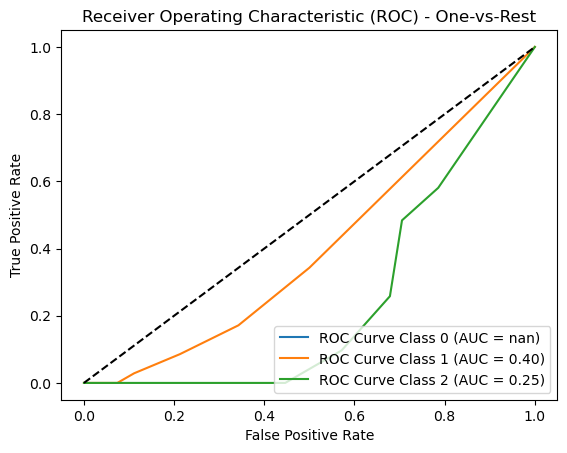

In [167]:
# Вычисление вероятностей принадлежности к каждому классу (One-vs-Rest)
knn_probabilities = knn.predict_proba(X_test)

# Вычисление ROC-кривой и AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_index in range(len(knn.classes_)):
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test, knn_probabilities[:, class_index], pos_label=class_index)
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])

# Построение ROC-кривых для каждого класса
plt.figure()
for class_index in range(len(knn.classes_)):
    plt.plot(fpr[class_index], tpr[class_index], label='ROC Curve Class %s (AUC = %0.2f)' % (class_index, roc_auc[class_index]))

plt.plot([0, 1], [0, 1], 'k--')  # Диагональная линия случайной классификации
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - One-vs-Rest')
plt.legend(loc='lower right')
plt.show()

Именно здесь было потрачена бОльшая часть времени - метод ROC Curve является бинарным, но для него придумали возможность применения OneVsRest, чтобы все-таки свести задачу к бинарному представлению - хорошо это или плохо, мы можем видеть на графике

Здесь мы можем наблюдать интересную картину:
Хороший результат, когда значение AUC -> 1 или хотя бы больше 0,5 (случайное бинарное предсказание). В нашем случае, ROC Curve говорит о плохом качестве пресказания как для k ближайших соседей, так и для дерева решений.

Но, справедливости ради, прерывистая линия хорошо описывает случайные равновероятностные распределения (например, идеальный бросок монетки действительно выражается отношением 50/50), что в нашем случае нельзя считать корректным.

# Построение ROC Curve для дерева решений

D:\Work Programs\Installed\Anaconda\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


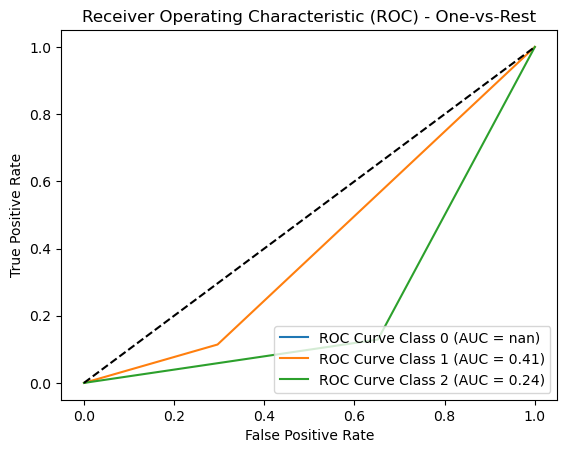

In [177]:
# Вычисление вероятностей принадлежности к каждому классу (One-vs-Rest)
dt_probabilities = dt.predict_proba(X_test)

# Вычисление ROC-кривой и AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_index in range(len(knn.classes_)):
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test, dt_probabilities[:, class_index], pos_label=class_index)
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])

# Построение ROC-кривых для каждого класса
plt.figure()
for class_index in range(len(knn.classes_)):
    plt.plot(fpr[class_index], tpr[class_index], label='ROC Curve Class %s (AUC = %0.2f)' % (class_index, roc_auc[class_index]))

plt.plot([0, 1], [0, 1], 'k--')  # Диагональная линия случайной классификации
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - One-vs-Rest')
plt.legend(loc='lower right')
plt.show()